## Output Probabilities for all subjects and ROC curve inputs for some kind of statistical anlysis of ROC curves

From request [ROC Output and Probabilities](https://trello.com/c/JcZRCXte)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished


Best parameters set found on development set:

{'classifier__C': 0.26366508987303555}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.84      0.95      0.89        55
        1.0       0.98      0.93      0.95       146

avg / total       0.94      0.94      0.94       201


Confusion matrix, without normalization
[[ 52   3]
 [ 10 136]]

recall	0.931506849315
precision	0.978417266187
auc	0.938480697385
specificity	0.945454545455
npv	0.838709677419
accuracy	0.935323383085
weighted_sensitivity	0.931506849315
weighted_ppv	0.944683000758
weighted_specificity	0.945454545455
weighted_npv	0.932449029722
weighted_accuracy	0.938480697385
TRAINNG PROBABILITIES
1.0 0.999999788442
1.0 0.903350936544
1.0 0.981873400863
1.0 0.999999909349
1.0 0.947943833374
0.0 0.0964568882361
1.0 0.99625970808
1.0 0.999998477086
0.0 0.0530589674

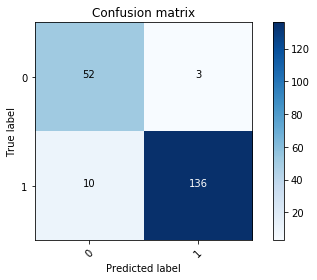

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0308047771454	0.0078786447404
score_time	0.0333987236023	0.00757185500744
test_recall	0.956776611694	0.0144262324184
train_recall	0.952424896917	0.0038350676308
test_precision	0.989502048912	0.0101073219706
train_precision	0.989226358129	0.00258777763245
test_auc	0.964903457362	0.0070110818047
train_auc	0.962757549206	0.00344653965836
test_specificity	0.97303030303	0.0263858801629
train_specificity	0.973090201494	0.00654236922719
test_npv	0.898533100897	0.0298998256809
train_npv	0.887615802625	0.00790729780196
test_accuracy	0.961318801516	0.0045001622242
train_accuracy	0.958179517134	0.00299255849198
test_weighted_sensitivity	0.956776611694	0.0144262324184
train_weighted_sensitivity	0.952424896917	0.0038350676308
test_weighted_ppv	0.973606543194	0.0253467335204
train_weighted_ppv	0.972570350359	0.00649615067371
test_weighted_specificity	0.97303030303	0.0263858801629
train_weighted_specificity	0.973090201494	0.00654236922719
test_weighted_npv	0.957959527842	0.0129763416091
tr

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.288963779886
Sex	-0.0804164368233
UPDRS	3.11382063017


             precision    recall  f1-score   support

        0.0       0.84      0.95      0.89        55
        1.0       0.98      0.93      0.95       146

avg / total       0.94      0.94      0.94       201

TESTING PROBABILITIES
1.0 0.999993523496
1.0 0.999999999997
1.0 0.999999924678
1.0 0.822710422226
0.0 0.0233470935122
0.0 0.0165344434147
1.0 0.997460868648
1.0 0.942028990558
1.0 1.0
1.0 0.961514358061
0.0 0.193184669248
0.0 0.065816856153
1.0 0.999999999986
0.0 0.285984545372
1.0 0.999999994582
1.0 0.999996576775
1.0 0.201876144341
0.0 0.0307431478006
1.0 0.999999973849
1.0 0.999999963258
1.0 0.334871070712
1.0 0.995992551026
1.0 0.99998953033
0.0 0.125016388741
0.0 0.0258541324346
1.0 1.0
1.0 0.99999998756
1.0 0.962886704755
1.0 0.999999671243
1.0 0.985584968606
1.0 0.99999999861
0.0 0.585710121409
0.0 0.06439521616
1.0 0.999999509851
1.0 0.999999999962
0.0 0.589288628603
0.0 0.0662050624513
1.0 0.980873866443
1.0 0.999999999059
1.0 0.899596706672
1.0 0.999999986013
1.0 0

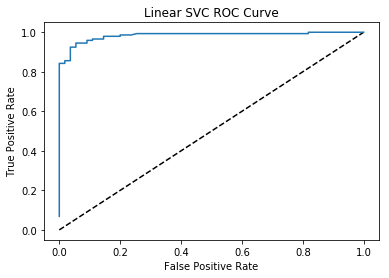

0.0 0.0684931506849
0.0 0.787671232877
0.0 0.801369863014
0.0 0.842465753425
0.0181818181818 0.842465753425
0.0181818181818 0.856164383562
0.0363636363636 0.856164383562
0.0363636363636 0.869863013699
0.0363636363636 0.883561643836
0.0363636363636 0.924657534247
0.0545454545455 0.924657534247
0.0545454545455 0.945205479452
0.0909090909091 0.945205479452
0.0909090909091 0.958904109589
0.109090909091 0.958904109589
0.109090909091 0.965753424658
0.145454545455 0.965753424658
0.145454545455 0.979452054795
0.163636363636 0.979452054795
0.2 0.979452054795
0.2 0.986301369863
0.236363636364 0.986301369863
0.254545454545 0.993150684932
0.690909090909 0.993150684932
0.727272727273 0.993150684932
0.818181818182 0.993150684932
0.818181818182 1.0
0.854545454545 1.0
0.872727272727 1.0
0.909090909091 1.0
1.0 1.0


In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.84      0.66      0.74       105
        1.0       0.43      0.68      0.52        40

avg / total       0.73      0.66      0.68       145


Confusion matrix, without normalization
[[69 36]
 [13 27]]

recall	0.675
precision	0.428571428571
auc	0.666071428571
specificity	0.657142857143
npv	0.841463414634
accuracy	0.662068965517
weighted_sensitivity	0.675
weighted_ppv	0.663157894737
weighted_specificity	0.657142857143
weighted_npv	0.669090909091
weighted_accuracy	0.666071428571
TRAINNG PROBABILITIES
0.0 0.366113406639
0.0 0.332964581369
0.0 0.288845745569
1.0 0.386972570823
0.0 0.193727603431
1.0 0.188743085144
0.0 0.296780984224
1.0 0.509001475618
0.0 0.187927972339
0.0 0.307077499966

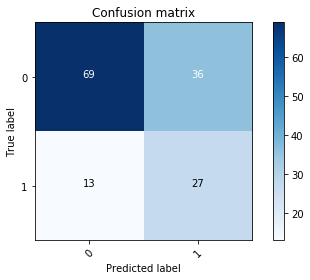

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0687260627747	0.013472987827
score_time	0.0507046222687	0.0145436075737
test_recall	0.415294117647	0.0985143508584
train_recall	0.432123866124	0.10824499327
test_precision	0.550094630516	0.110571631955
train_precision	0.560547145228	0.0414186556099
test_auc	0.629974670989	0.0420090671383
train_auc	0.641560508561	0.029769641805
test_specificity	0.84465522433	0.0685517497936
train_specificity	0.850997150997	0.0579173732415
test_npv	0.773584963151	0.0246730091266
train_npv	0.780743537624	0.024581265573
test_accuracy	0.716529812017	0.0395253424351
train_accuracy	0.725801032648	0.0165199754915
test_weighted_sensitivity	0.415294117647	0.0985143508584
train_weighted_sensitivity	0.432123866124	0.10824499327
test_weighted_ppv	0.734713214889	0.0825367805636
train_weighted_ppv	0.74863872159	0.0310099648178
test_weighted_specificity	0.84465522433	0.0685517497936
train_weighted_specificity	0.850997150997	0.0579173732415
test_weighted_npv	0.593590891507	0.0368630280747
train_weighted_npv	

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.185307163756
Sex	0.0
UPDRS	0.35593414589


             precision    recall  f1-score   support

        0.0       0.84      0.66      0.74       105
        1.0       0.43      0.68      0.52        40

avg / total       0.73      0.66      0.68       145

TESTING PROBABILITIES
1.0 0.277080704219
0.0 0.155553939424
0.0 0.180472891674
0.0 0.265764324187
0.0 0.297682457372
0.0 0.785047588749
0.0 0.373841972602
0.0 0.175314640913
0.0 0.147799771801
0.0 0.193905919675
1.0 0.435936102868
0.0 0.189443043446
1.0 0.360667497094
0.0 0.283350861654
0.0 0.171314440443
1.0 0.354806617792
1.0 0.289158407617
0.0 0.575048012067
0.0 0.408348597389
1.0 0.277385598324
0.0 0.424433642582
0.0 0.283659948152
0.0 0.182017484374
0.0 0.123747720644
0.0 0.449892488237
1.0 0.465384094584
1.0 0.707479936562
0.0 0.335988633651
0.0 0.649379493303
0.0 0.220823650212
0.0 0.214556765623
1.0 0.306672933997
1.0 0.479448597528
1.0 0.265615891292
1.0 0.408619554429
1.0 0.414487194294
0.0 0.222421200191
1.0 0.61025619223
1.0 0.524150212844
0.0 0.184658050448
0.0 

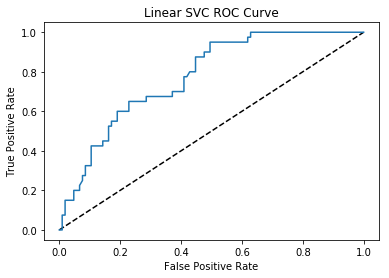

0.0 0.0
0.00952380952381 0.0
0.00952380952381 0.075
0.0190476190476 0.075
0.0190476190476 0.15
0.047619047619 0.15
0.047619047619 0.2
0.0666666666667 0.2
0.0666666666667 0.225
0.0761904761905 0.25
0.0761904761905 0.275
0.0857142857143 0.275
0.0857142857143 0.325
0.104761904762 0.325
0.104761904762 0.425
0.142857142857 0.425
0.142857142857 0.45
0.161904761905 0.45
0.161904761905 0.525
0.171428571429 0.525
0.171428571429 0.55
0.190476190476 0.55
0.190476190476 0.6
0.228571428571 0.6
0.228571428571 0.65
0.285714285714 0.65
0.285714285714 0.675
0.371428571429 0.675
0.371428571429 0.7
0.409523809524 0.7
0.409523809524 0.775
0.419047619048 0.775
0.428571428571 0.8
0.447619047619 0.8
0.447619047619 0.875
0.47619047619 0.875
0.47619047619 0.9
0.495238095238 0.9
0.495238095238 0.95
0.619047619048 0.95
0.619047619048 0.975
0.628571428571 0.975
0.628571428571 1.0
0.638095238095 1.0
0.657142857143 1.0
0.72380952381 1.0
0.752380952381 1.0
0.895238095238 1.0
0.914285714286 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.96      0.73      0.83       131
        1.0       0.22      0.71      0.34        14

avg / total       0.89      0.73      0.78       145


Confusion matrix, without normalization
[[96 35]
 [ 4 10]]

recall	0.714285714286
precision	0.222222222222
auc	0.723555070883
specificity	0.732824427481
npv	0.96
accuracy	0.731034482759
weighted_sensitivity	0.714285714286
weighted_ppv	0.727777777778
weighted_specificity	0.732824427481
weighted_npv	0.71948608137
weighted_accuracy	0.723555070883
TRAINNG PROBABILITIES
0.0 0.12585346876
0.0 0.0913658497156
0.0 0.108781453317
1.0 0.221226678933
0.0 0.0468168619976
0.0 0.0613718010276
0.0 0.1105729254
1.0 0.294267391236
0.0 0.041942811852
0.0 0.12940

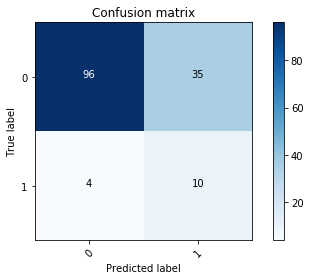

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0475967884064	0.00627253646537
score_time	0.0406018257141	0.0100261873931
test_recall	0.485714285714	0.193780856661
train_recall	0.535714285714	0.0822204602373
test_precision	0.318916857361	0.105131081535
train_precision	0.347858194192	0.0394311883351
test_auc	0.672123304767	0.100771504376
train_auc	0.696884097619	0.0281296820237
test_specificity	0.858532323821	0.0332165958017
train_specificity	0.858053909524	0.0408045775009
test_npv	0.924371111999	0.0273218632805
train_npv	0.931132347721	0.00935724549593
test_accuracy	0.813418290855	0.0401979473488
train_accuracy	0.819081887242	0.0287476485394
test_weighted_sensitivity	0.485714285714	0.193780856661
train_weighted_sensitivity	0.535714285714	0.0822204602373
test_weighted_ppv	0.755162581733	0.0824206748744
train_weighted_ppv	0.792767580782	0.029092051482
test_weighted_specificity	0.858532323821	0.0332165958017
train_weighted_specificity	0.858053909524	0.0408045775009
test_weighted_npv	0.63862337881	0.0995113838043
train_weight

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.0153615050874
Sex	0.0
UPDRS	0.450545817449


             precision    recall  f1-score   support

        0.0       0.96      0.73      0.83       131
        1.0       0.22      0.71      0.34        14

avg / total       0.89      0.73      0.78       145

TESTING PROBABILITIES
1.0 0.0953350460187
0.0 0.0434210926402
0.0 0.0385667714752
0.0 0.0765197211517
0.0 0.131489226905
0.0 0.682300413289
0.0 0.189662162434
0.0 0.0723992434149
0.0 0.0495047135237
0.0 0.0407854244981
0.0 0.250677443688
0.0 0.0370693146111
1.0 0.188643006923
0.0 0.0806257083547
0.0 0.0437761516856
1.0 0.253866013437
0.0 0.091931174008
0.0 0.320531554693
0.0 0.171381602906
0.0 0.0803797717159
0.0 0.188362866881
0.0 0.0678049618848
0.0 0.0624400474547
0.0 0.0402643870765
0.0 0.308356919415
0.0 0.22758729921
0.0 0.620477692362
0.0 0.130907306324
0.0 0.63642698523
0.0 0.0956387975867
0.0 0.0792903798371
1.0 0.158096246482
0.0 0.291514992826
0.0 0.0833952157391
0.0 0.15236903839
1.0 0.2488098432
0.0 0.0655310734798
1.0 0.5
1.0 0.258240653723
0.0 0.0465126482583


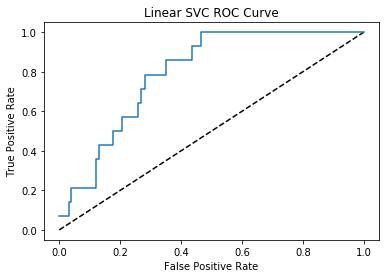

0.0 0.0714285714286
0.030534351145 0.0714285714286
0.030534351145 0.142857142857
0.0381679389313 0.142857142857
0.0381679389313 0.214285714286
0.12213740458 0.214285714286
0.12213740458 0.357142857143
0.129770992366 0.357142857143
0.129770992366 0.428571428571
0.160305343511 0.428571428571
0.175572519084 0.428571428571
0.175572519084 0.5
0.206106870229 0.5
0.206106870229 0.571428571429
0.259541984733 0.571428571429
0.259541984733 0.642857142857
0.267175572519 0.642857142857
0.267175572519 0.714285714286
0.282442748092 0.714285714286
0.282442748092 0.785714285714
0.351145038168 0.785714285714
0.351145038168 0.857142857143
0.435114503817 0.857142857143
0.435114503817 0.928571428571
0.465648854962 0.928571428571
0.465648854962 1.0
0.480916030534 1.0
0.496183206107 1.0
0.587786259542 1.0
0.603053435115 1.0
0.786259541985 1.0
0.801526717557 1.0
0.809160305344 1.0
0.832061068702 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.91      0.70      0.79       119
        1.0       0.33      0.69      0.45        26

avg / total       0.81      0.70      0.73       145


Confusion matrix, without normalization
[[83 36]
 [ 8 18]]

recall	0.692307692308
precision	0.333333333333
auc	0.694893341952
specificity	0.697478991597
npv	0.912087912088
accuracy	0.696551724138
weighted_sensitivity	0.692307692308
weighted_ppv	0.695906432749
weighted_specificity	0.697478991597
weighted_npv	0.693890675241
weighted_accuracy	0.694893341952
TRAINNG PROBABILITIES
0.0 0.182764573836
0.0 0.18217945071
0.0 0.159852544304
0.0 0.167075877636
0.0 0.149480198458
1.0 0.137652017508
0.0 0.162278684363
0.0 0.196743437538
0.0 0.150097308763
0

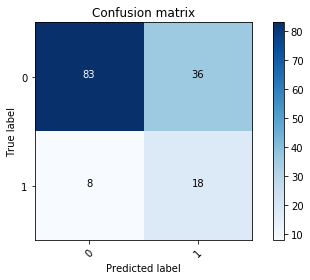

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0167103290558	0.00493773232928
score_time	0.0121001720428	0.00387884404707
test_recall	0.511428571429	0.261798246739
train_recall	0.480928592418	0.221167832567
test_precision	0.274287749288	0.0764170333797
train_precision	0.260151462932	0.0358350208701
test_auc	0.596931390977	0.0554553437964
train_auc	0.577156518892	0.0198751413238
test_specificity	0.682434210526	0.213638550022
train_specificity	0.673384445365	0.230535330258
test_npv	0.885746169632	0.0601814724188
train_npv	0.866584619016	0.0278916275826
test_accuracy	0.652737221133	0.133683742868
train_accuracy	0.638997370582	0.151107140213
test_weighted_sensitivity	0.511428571429	0.261798246739
train_weighted_sensitivity	0.480928592418	0.221167832567
test_weighted_ppv	0.625472056629	0.0756753036518
train_weighted_ppv	0.615983564919	0.0456001629906
test_weighted_specificity	0.682434210526	0.213638550022
train_weighted_specificity	0.673384445365	0.230535330258
test_weighted_npv	0.652603928672	0.178478699773
train_weighted_np

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.259272736023
Sex	0.0
UPDRS	0.15470416631


             precision    recall  f1-score   support

        0.0       0.91      0.70      0.79       119
        1.0       0.33      0.69      0.45        26

avg / total       0.81      0.70      0.73       145

TESTING PROBABILITIES
0.0 0.160029389057
0.0 0.132933433981
0.0 0.149007115579
0.0 0.163297859371
0.0 0.156307366498
0.0 0.256439517518
0.0 0.168853050095
0.0 0.126766063777
0.0 0.125389452654
0.0 0.15388076204
1.0 0.178638715364
0.0 0.154710451677
0.0 0.164288004278
0.0 0.168546335397
0.0 0.140638032989
0.0 0.150165808996
1.0 0.166072269793
0.0 0.217279452708
0.0 0.18582599069
1.0 0.166254633647
0.0 0.187586935594
0.0 0.175033848284
0.0 0.134087154959
0.0 0.117964258255
0.0 0.173486673905
1.0 0.193781128488
1.0 0.224827672064
0.0 0.169407928561
0.0 0.196465202042
0.0 0.13766212038
0.0 0.140977096646
0.0 0.152826509381
1.0 0.186556254093
1.0 0.160206392142
1.0 0.191056164638
0.0 0.171515362047
0.0 0.150430077665
0.0 0.200722365192
0.0 0.209442904098
0.0 0.145347307955
0.0 0.

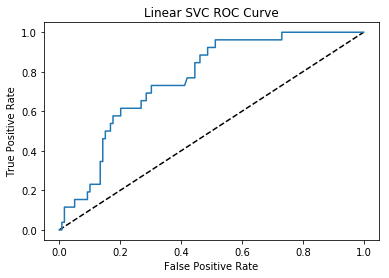

0.0 0.0
0.00840336134454 0.0
0.00840336134454 0.0384615384615
0.0168067226891 0.0384615384615
0.0168067226891 0.115384615385
0.0504201680672 0.115384615385
0.0504201680672 0.153846153846
0.0924369747899 0.153846153846
0.0924369747899 0.192307692308
0.100840336134 0.192307692308
0.100840336134 0.230769230769
0.134453781513 0.230769230769
0.134453781513 0.346153846154
0.142857142857 0.346153846154
0.142857142857 0.461538461538
0.151260504202 0.461538461538
0.151260504202 0.5
0.168067226891 0.5
0.168067226891 0.538461538462
0.176470588235 0.538461538462
0.176470588235 0.576923076923
0.201680672269 0.576923076923
0.201680672269 0.615384615385
0.268907563025 0.615384615385
0.268907563025 0.653846153846
0.285714285714 0.653846153846
0.285714285714 0.692307692308
0.302521008403 0.692307692308
0.302521008403 0.730769230769
0.411764705882 0.730769230769
0.420168067227 0.769230769231
0.445378151261 0.769230769231
0.445378151261 0.846153846154
0.46218487395 0.846153846154
0.46218487395 0.88461538

In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    9.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.31      0.38      0.34        13
        1.0       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[ 5  8]
 [11 19]]

recall	0.633333333333
precision	0.703703703704
auc	0.508974358974
specificity	0.384615384615
npv	0.3125
accuracy	0.558139534884
weighted_sensitivity	0.633333333333
weighted_ppv	0.507186858316
weighted_specificity	0.384615384615
weighted_npv	0.511945392491
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
1.0 0.48655534789
0.0 0.573237175416
0.0 0.11570585238
1.0 0.893464491371
1.0 0.332521039955
1.0 0.839125338957
1.0 0.836584005103
0.0 0.454040194316
1.0 0.898566692707
1.0 0.6837

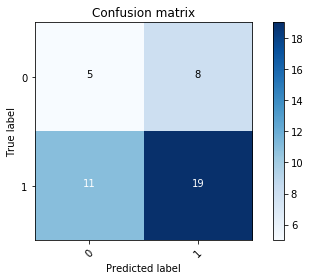

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00329689979553	0.0003995894077
score_time	0.00789222717285	0.00149375379654
test_recall	0.667894736842	0.105215778811
train_recall	0.676803797468	0.0228873396369
test_precision	0.781764507422	0.0957109683723
train_precision	0.782399129074	0.0346019059782
test_auc	0.699661654135	0.0901241911717
train_auc	0.706290369912	0.0301353128205
test_specificity	0.731428571429	0.124343172269
train_specificity	0.735776942356	0.0491779203385
test_npv	0.616666666667	0.104436724759
train_npv	0.619871740064	0.0277935226111
test_accuracy	0.693868092692	0.0887190398129
train_accuracy	0.701463591114	0.0277940644804
test_weighted_sensitivity	0.667894736842	0.105215778811
train_weighted_sensitivity	0.676803797468	0.0228873396369
test_weighted_ppv	0.723503060295	0.116868020371
train_weighted_ppv	0.720987818774	0.042248042129
test_weighted_specificity	0.731428571429	0.124343172269
train_weighted_specificity	0.735776942356	0.0491779203385
test_weighted_npv	0.689550608599	0.0890769851567
train_weight

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.259272736023
Sex	0.0
UPDRS	0.15470416631


             precision    recall  f1-score   support

        0.0       0.31      0.38      0.34        13
        1.0       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
0.0 0.36462632308
1.0 0.816264677357
1.0 0.354768627129
0.0 0.703145430012
0.0 0.621694049302
1.0 0.642835757195
0.0 0.527799896138
0.0 0.645573246731
1.0 0.5
1.0 0.674012840741
1.0 0.556165835372
1.0 0.246757317244
1.0 0.485324629849
0.0 0.846817310621
0.0 0.629071867582
1.0 0.700057011068
1.0 0.615068449229
1.0 0.748932786667
1.0 0.771324541741
1.0 0.392757076758
0.0 0.609354533076
1.0 0.657914230297
1.0 0.429106043674
0.0 0.741528657822
1.0 0.8796228928
1.0 0.669680851475
1.0 0.797093915687
1.0 0.448708205058
1.0 0.80390224042
1.0 0.72363043736
1.0 0.346175202447
0.0 0.22808172307
1.0 0.651845161991
0.0 0.346067628641
1.0 0.428988835072
0.0 0.3084322842
1.0 0.819200039449
1.0 0.580379804847
1.0 0.629321490274
1.0 0.645647822933
0.0 0.692091495001
1.0

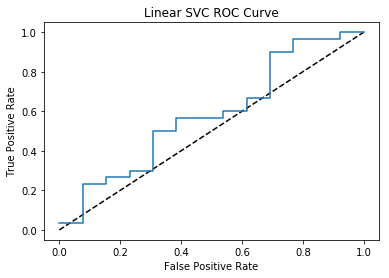

0.0 0.0333333333333
0.0769230769231 0.0333333333333
0.0769230769231 0.233333333333
0.153846153846 0.233333333333
0.153846153846 0.266666666667
0.230769230769 0.266666666667
0.230769230769 0.3
0.307692307692 0.3
0.307692307692 0.5
0.384615384615 0.5
0.384615384615 0.566666666667
0.538461538462 0.566666666667
0.538461538462 0.6
0.615384615385 0.6
0.615384615385 0.666666666667
0.692307692308 0.666666666667
0.692307692308 0.9
0.769230769231 0.9
0.769230769231 0.966666666667
0.923076923077 0.966666666667
0.923076923077 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.70      0.63      0.67        30
        1.0       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[19 11]
 [ 8  5]]

recall	0.384615384615
precision	0.3125
auc	0.508974358974
specificity	0.633333333333
npv	0.703703703704
accuracy	0.558139534884
weighted_sensitivity	0.384615384615
weighted_ppv	0.511945392491
weighted_specificity	0.633333333333
weighted_npv	0.507186858316
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
0.0 0.51636464216
1.0 0.417205686295
1.0 0.912897963591
0.0 0.0795544081675
0.0 0.695274658061
0.0 0.130141197769
0.0 0.132566687678
1.0 0.554001314429
0.0 0.0751761373311
0.0 0.2

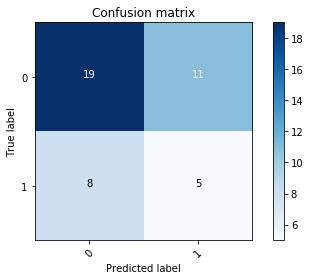

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being 

fit_time	0.00736560821533	0.00472180457008
score_time	0.0211225986481	0.00978658707023
test_recall	0.2	0.4
train_recall	0.2	0.4
test_precision	0.0848484848485	0.169696969697
train_precision	0.0832116788321	0.166423357664
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.8	0.4
train_specificity	0.8	0.4
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.552075375605	0.064247068047
train_accuracy	0.548778127634	0.0663807883962
test_weighted_sensitivity	0.2	0.4
train_weighted_sensitivity	0.2	0.4
test_weighted_ppv	nan	nan
train_weighted_ppv	nan	nan
test_weighted_specificity	0.8	0.4
train_weighted_specificity	0.8	0.4
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in double_scalars


In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.591393122754
Sex	-0.18840053372
UPDRS	0.661648238171


             precision    recall  f1-score   support

        0.0       0.70      0.63      0.67        30
        1.0       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
1.0 0.65758772263
0.0 0.152476335297
0.0 0.668474644522
1.0 0.270299445984
1.0 0.364690813509
0.0 0.344100749343
1.0 0.468739895239
1.0 0.337653114639
0.0 0.5
0.0 0.302873444853
0.0 0.436406123369
0.0 0.784105166973
0.0 0.517940692808
1.0 0.122720436895
1.0 0.357349995389
0.0 0.273778987877
0.0 0.371484987793
0.0 0.22160655862
0.0 0.198099815915
0.0 0.62670865182
1.0 0.377993213839
0.0 0.32012208626
0.0 0.583041262867
1.0 0.229107922233
0.0 0.0919655831335
0.0 0.307649373743
0.0 0.171728780539
0.0 0.559996120459
0.0 0.164485535314
0.0 0.248201286125
0.0 0.67871506622
1.0 0.80371883037
0.0 0.330933329907
1.0 0.678951562085
0.0 0.583085264987
1.0 0.718011775777
0.0 0.149531129924
0.0 0.408948927262
0.0 0.356974788451
0.0 0.337027814442
1.0 0.282915982896


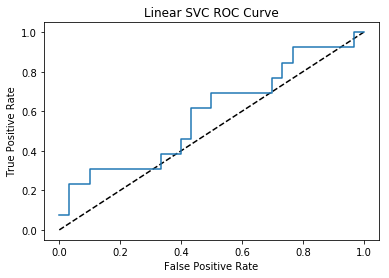

0.0 0.0769230769231
0.0333333333333 0.0769230769231
0.0333333333333 0.230769230769
0.1 0.230769230769
0.1 0.307692307692
0.333333333333 0.307692307692
0.333333333333 0.384615384615
0.4 0.384615384615
0.4 0.461538461538
0.433333333333 0.461538461538
0.433333333333 0.615384615385
0.5 0.615384615385
0.5 0.692307692308
0.7 0.692307692308
0.7 0.769230769231
0.733333333333 0.769230769231
0.733333333333 0.846153846154
0.766666666667 0.846153846154
0.766666666667 0.923076923077
0.966666666667 0.923076923077
0.966666666667 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)